## Machine Learning Classification with Python - SciKitLearn

### 1. Introduction

Machine Learning algorithms allow us to read huge datasets and extract underlying patterns so that we can make predictions according to these patterns in a way that -far from being statistically perfect- would be impossible using classical methods in a reasonable period of time.
In this notebook we want to predict if the new clients asking for a loan in a bank are likely going to pay off their debts or not, hence classifying the customer's profiles in two groups.
For this purpose, we will load and read a dataset of former loans using Pandas library, apply four different classification algorithms, and find which is the best classificator for this specific dataset, measured by three different accuracy evaluation methods.

Let's first load required libraries:

In [1]:
import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
import warnings
warnings.filterwarnings("ignore") # This is to avoid unconvenient Deprecation Warnings (pink boxes)
                                  # that pop up when calling some datatypes with newer versions of NumPy
                                 

### 2. About the dataset

The dataset is a collection describing loans taken by the clients of a bank. The __Loan_train.csv__ data set includes details of 346 customers whose loans are already paid off or defaulted. It includes the following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Let's download the dataset:

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2021-07-15 23:07:56--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.01s   

2021-07-15 23:07:56 (1.51 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### 3. Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

# Data visualization and pre-processing

### 0. Convert to date time object 

The loan dates are expressed in mm/dd/yyyy format, let's transform them to a more easy-going format with to_datetime method:

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection.


### 1. Data visualization

Lets plot some columns for the sake of clarity and better understanding:

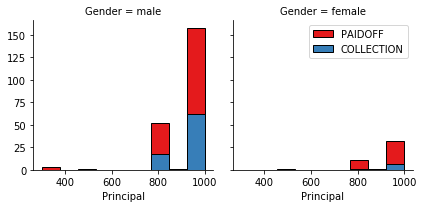

In [7]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)                    # Split the range of Principal (amount) by 10
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)# Split by status and graph by gender.
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

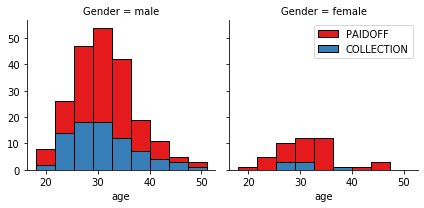

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)                                # Split the range of ages in 10 stripes
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)# Split by status and graph by gender.
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

### 0. Convert to date time object 

The loan dates are expressed in mm/dd/yyyy format, let's transform them to a more easy-going format with to_datetime method:### 2. Pre-processing (I):  Feature selection/extraction

Let's look at the day of the week people got the loan:

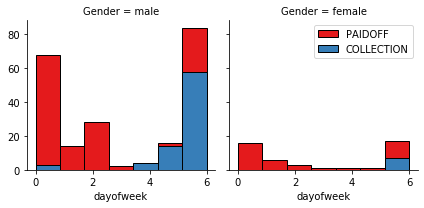

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek                   #This method allows us to transform dates to week days
                                                                      #We add this new column to the DataFrame
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 8)         #Assuming these banks were opening on weekends.
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")                       #Let's plot (histogram) the loans as a f(dayofweek).
g.axes[-1].legend()
plt.show()


We see that the majority of men who got the loan at the end of the week didn't pay it off, so lets use Feature binarization to set a threshold values less then day 4 (friday):

In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


### 2. Pre-processing (II): Convert Categorical features to numerical values

Let's look for gender differences:

In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % women paid their loans, while only 73 % of males did.

Let's replace the gender column for numerical values: male to 0 and female to 1:


In [12]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


### 2. Pre-processing (III): One Hot Encoding  

Let's look for education differences:

In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In this case there are no obvious differences. There were only 2 Master entries so those stats does not seem valid to me, so I'll drop them...
We'll use one-hot encoding technique to convert categorical variables to columns with binary variables and append them to the DataFrame: 

In [14]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature=Feature.rename(columns={'Bechalor':'Bachelor', 'High School or Below':'High School', 'college':'College'}) #There were some typos in the dataset
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Pre-processing (IV): Splitting into Features and Labels

Let's define features set (X):

In [16]:
X = Feature  
X[0:5]

,Principal,terms,age,Gender,weekend,Bachelor,High School,College
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [17]:
X = np.asarray(Feature)  #we need to convert the datasets from pandas DFs to numpy arrays in order to pass the scikit scripts.
X[0:5]

array([[1000,   30,   45,    0,    0,    0,    1,    0],
       [1000,   30,   33,    1,    0,    1,    0,    0],
       [1000,   15,   27,    0,    0,    0,    0,    1],
       [1000,   30,   28,    1,    1,    0,    0,    1],
       [1000,   30,   29,    0,    1,    0,    0,    1]])

And now the labels column:

In [18]:
#df['loan_status']=df['loan_status'].astype('int')
#y = np.asarray(df['loan_status'].values)        #We may try to use any of these 3 snippets to take the labels column and see what happens
y = df['loan_status'].values                     #The labels column is the Loan status: Paid off or In collection.
y[0:5]

unique, counts = np.unique(y, return_counts=True) #checking the number of Paidoffs/Colections is consistent with the dataset.
dict(zip(unique, counts))

{'COLLECTION': 86, 'PAIDOFF': 260}

#### Plotting features & labels

Let's plot the three first column features: terms vs. age vs. Principal (the loan mount), and colour them differently if paidoff or not (labels).
The aim of this exercise is to devise a classificator that accurately splits the two colour groups.

There is a major concern in these kinds of applications: overfitting. When devising a classificator and training the machine, there is a big risk of training the machine so that it learns to split our ttraining data, not being able to make accurate predictions on real data. There are several strategies to avoid this overfitting, but they are out of the scope of this exercise.

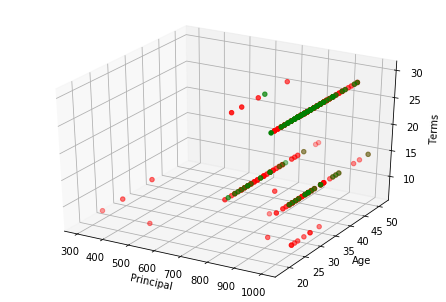

In [21]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

fig = pyplot.figure()
ax = Axes3D(fig)

colors = {'PAIDOFF':'red', 'COLLECTION':'green'}  

ax.scatter(df['Principal'], df['age'], df['terms'], c=df['loan_status'].map(colors))
ax.set_xlabel('Principal')
ax.set_ylabel('Age')
ax.set_zlabel('Terms')

plt.show()

As you may see, there is no obvious plane that clearly splits the two populations, green and red. Thus, every classifier's prediction will have to assume an error rate.

### 2. Pre-processing (V): Normalize Numerical values

Data Standardization transforms data to a distribution with zero mean and unit variance (technically should be done after train/test split). This step is fundamental to avoid the bias produced by the different scales of every column in the dataset.

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:2]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108]])

# Classification 

We may know classify the dataset using the best of these 4 algorithms:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression

All of them will ultimately separate the profiles belonging to customers that seem less likely to be paying off their debts from those profiles that correspond to payers. For this purpose they use different strategies, but all of them have in common that take a number of "train" profiles with the final output (Paidoff/Collection) and test the classificator system with another portion of the dataset ("test").

In [20]:
#first we split the dataset into train and test:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


### 1. K Nearest Neighbor (KNN)

In this kind of classification algorithm we try to assign our data points to a group using the group to which the k nearest neighbors belong to. 
That is, if a data point (in this case, a client's entry in the database) is represented in a multi-dimensional space, it will belong to group A 
(e.g., Paidoff) if the closest point (the most similar client) belongs to A group. More neighbors are taken into account as k increases, but also computing time increases dramatically.


In [21]:
#we can now launch the training, I'm going to use a range of different k (from 1 to 30) to optimize this parameter:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Ks=30
mean_acc=np.zeros((Ks-1))
std_acc=np.zeros((Ks-1))

for n in range(1,Ks):
        
    kNN_model = KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
    
    yhat = kNN_model.predict(X_test)
        
    mean_acc[n-1]=np.mean(yhat==y_test);
    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
mean_acc


array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286, 0.67142857,
       0.7       , 0.72857143, 0.7       , 0.7       , 0.68571429,
       0.72857143, 0.72857143, 0.72857143, 0.7       , 0.68571429,
       0.71428571, 0.68571429, 0.7       , 0.7       , 0.72857143,
       0.71428571, 0.77142857, 0.68571429, 0.78571429])

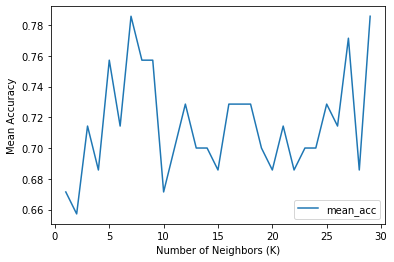

In [22]:
#and plot the resulting accuracies against number of neighbours
import matplotlib.pyplot as plt
plt.plot(range(1, Ks), mean_acc, label='mean_acc')
plt.ylabel('Mean Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.legend()
plt.show()

k=7 and k=29 seem pretty fair results with similar good train and test accuracies, I chose k=5 as 29 neighbors will be too time consuming for no relevant improvement.

In [23]:
#Train model and predict
kNN_model = KNeighborsClassifier(n_neighbors=5).fit(X_train,y_train)
yhat_knn=kNN_model.predict(X_test)

print ("Test dataset:", y_test [0:6])
print ("Prediction:  ", yhat_knn[0:6])

Test dataset: ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
Prediction:   ['PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


### 2. Decision Tree

When coming to decission trees we sought to find the most informative way to split (bifurcate) the data to build a tree that minimizes the information entropy of the system. Obviously, building a tree with enough ramifications would perfectly separate every data point, but it would be time consuming (and, maybe, pointleess), our objective is to build a tree with no more than 4 or 5 bifurcation steps.

In [24]:
from sklearn.tree import DecisionTreeClassifier
DT_model = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
DT_model.fit(X_train, y_train)
yhat = DT_model.predict(X_test)
print ("Test dataset:", y_test [0:6])
print ("Prediction:  ", yhat  [0:6])

print("Accuracy:",metrics.accuracy_score(y_test, yhat))

Test dataset: ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
Prediction:   ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
Accuracy: 0.7714285714285715


In [ ]:
#If we want to visualize the decission tree we will need 2 libraries: graphviz and pydotplus
#Installing libraries in Jupyter Notebook may be really messy as explained here: 
# https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
#so, if you find no success after any of the installing options in this particular cell, just skip it.

import sys  #Option 1
!conda install --yes --prefix {sys.prefix} graphviz         
!conda install --yes --prefix {sys.prefix} pydotplus

import sys  #Option 2
!{sys.executable} -m pip install graphviz 
!{sys.executable} -m pip install pydotplus

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(DT_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = Feature.columns, class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('loan_tree.png')
Image(graph.create_png())

### 3. Support Vector Machine

In this type of classification we carry and transform data to a higher dimensional space in which we may find a hyperplane that maximizes the distance among groups. The nearest points to this hyperplane form the so-called support vector. The transformation process is called "kernelization" and there a few of them: linear, nonlinear, polynomial, radial basis function (RBF), sigmoid...

In [ ]:
#First attempt, I think it was fine, but received bad calification:
#again, I'll test the different kernelling methods to check the best one


#rbf = svm.SVC(kernel='rbf')
#lin = svm.SVC(kernel='linear')
#poly= svm.SVC(kernel='poly')
#sigm= svm.SVC(kernel='sigmoid')

#rbf.fit(X_train, y_train)
#y_rbf = rbf.predict(X_test)

#lin.fit(X_train, y_train)
#y_lin = lin.predict(X_test)  #this algorithm generates only zeroes

#poly.fit(X_train, y_train) 
#y_poly =poly.predict(X_test)

#sigm.fit(X_train, y_train) 
#y_sigm = sigm.predict(X_test)

#print(y_rbf [0:32])
#print(y_test [0:32])

In [34]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[48  7]
 [11  4]]
Classification report: 
               precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

    accuracy                           0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70



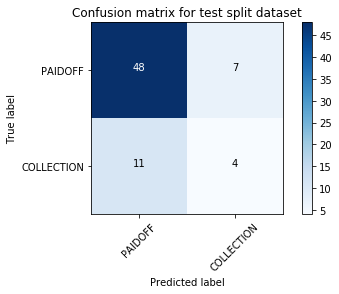

In [35]:
SVM_model = svm.SVC()
SVM_model.fit(X_train, y_train) 
yhat = SVM_model.predict(X_test)

cnf_matrix = confusion_matrix(y_test, yhat, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

#print ("Using rbf algorithm: \n", classification_report(y_test, y_rbf))
#print ("Using linear algorithm: \n", classification_report(y_test, y_lin)) #for any reason, linear algorithm does not predict any client as COLLECTION (1)
#print ("Using polynomial algorithm: \n", classification_report(y_test, y_poly)) #this algorithm has a 77% accuracy, still predicting some "1"s, so I choose it
#print ("Using sigmoid algorithm: \n", classification_report(y_test, y_sigm))

# Plotting non-normalized confusion matrix for linear algorithm
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix for test split dataset')
print ("Classification report: \n", classification_report(y_test, yhat))


### 4. Logistic Regression

In this case, we try to plot a sigmoid function that splits data in two groups in function of a variable Xi (only possible for cases like this, where labels only take 2 possible options). To avoid overfitting we use "C", the inverse of regularization.

In [36]:
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression(C=0.01).fit(X_train,y_train)
y_LR = LR_model.predict(X_test)

print ("Test dataset:", y_test [0:6])
print ("Prediction:  ", y_LR[0:6])

Test dataset: ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
Prediction:   ['COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


# Model Evaluation using validation dataset

In [37]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

### 1. Download the dataset

First, download the validation dataset:

In [38]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-07-15 17:38:16--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-07-15 17:38:16 (412 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### 2. Load Test set for evaluation 

In [39]:
#I have to preprocess the DataFrame in the same way I did before with the train dataset:
#labels:
#test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
#y=np.asarray(test_df['loan_status'].values)          #same here
#print(y[0:5])

#unique, counts = np.unique(y, return_counts=True) nt
#dict(zip(unique, counts))

test_df = pd.read_csv('loan_test.csv')
test_df.head()

test_y = test_df['loan_status'].values
test_y[0:5]

#independent variables:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
features = test_df[['Principal','terms','age','Gender','weekend']]
test_df = pd.concat([features,pd.get_dummies(test_df['education'])], axis=1)
test_df.drop(['Master or Above'], axis = 1,inplace=True)
#test_df.head()

#x=np.asarray(test_df)
test_x=preprocessing.StandardScaler().fit(test_df).transform(test_df)
test_x[0:5]

array([[ 0.49,  0.93,  3.06,  1.98, -4.12,  2.4 , -0.8 , -0.86],
       [-3.56, -1.7 ,  0.53, -0.51, -4.12, -0.42, -0.8 , -0.86],
       [ 0.49,  0.93,  1.88,  1.98, -4.12, -0.42,  1.25, -0.86],
       [ 0.49,  0.93, -0.98, -0.51,  0.24, -0.42, -0.8 ,  1.16],
       [-0.67, -0.79, -0.48, -0.51,  0.24,  2.4 , -0.8 , -0.86]])

### 3. Evaluation metrics

When we perform a classification task with any algorithm we have several ways to compare the prediction to the actual expected output of our model and measure the differences between them. Here, we will use the Jaccard Score, F1 score and Log Loss.

In [40]:
from sklearn.metrics import jaccard_score
#KNN (Now we have to train and test the KNN classifier with only k=7):

#Jacc_7nn= jaccard_score   (test_y, y_7nn, pos_label=0)
#f1_7nn  = metrics.f1_score(test_y, y_7nn, pos_label=0)
#print("Jaccard score is: ", Jacc_7nn)
#print("F1 score is: ", f1_7nn)

neigh = KNeighborsClassifier(n_neighbors = 7).fit(X,y)  #now we may use the whole dataset for training
y_7nn = neigh.predict(test_x)
#print(y_7nn)

print("KNN Jaccard index: %.2f" % jaccard_score(test_y, y_7nn, pos_label='PAIDOFF'))
print("KNN F1-score: %.2f" % f1_score(test_y, y_7nn, average='weighted') )

KNN Jaccard index: 0.65
KNN F1-score: 0.63


In [41]:
#Decision Tree (I use depth=5 as I found it the most accurate with train_dataset)

#y_tree = LoanTree.predict(X)
#Jacc_tree= jaccard_score   (y, y_tree, pos_label=0)
#f1_tree  = metrics.f1_score(y, y_tree, pos_label=0)
#print("Jaccard score is: ", Jacc_tree)
#print("F1 score is: ", f1_tree)
DT_model
DT_yhat = DT_model.predict(test_x)
print("DT Jaccard index: %.2f" % jaccard_score(test_y, DT_yhat, pos_label='PAIDOFF'))
print("DT F1-score: %.2f" % f1_score(test_y, DT_yhat, average='weighted') )


DT Jaccard index: 0.67
DT F1-score: 0.65


In [42]:
#Support Vector Machine (Now I will be using the polynomial solver as it seems the most accurate):
#y_svm =poly.predict(x)
#Jacc_svm= jaccard_score   (y, y_svm, pos_label=0)
#f1_svm  = metrics.f1_score(y, y_svm, pos_label=0)
#print("Jaccard score is: ", Jacc_svm)
#print("F1 score is: ", f1_svm)

#Second attempt: I'm going to train the SVM with the whole initial dataset
SVM_model = svm.SVC()
SVM_model.fit(X, y) 
SVM_yhat = SVM_model.predict(test_x)
print("SVM Jaccard index: %.2f" % jaccard_score(test_y, SVM_yhat, pos_label='PAIDOFF'))
print("SVM F1-score: %.2f" % f1_score(test_y, SVM_yhat, average='weighted') )

SVM Jaccard index: 0.72
SVM F1-score: 0.62


In [43]:
#Logistic Regression (once more, I have to re-train the classifier with the optimum parameter, c=0.001):
#LR_final = LogisticRegression(C=0.001, solver='liblinear').fit(X_train,y_train)

#y_LRfinal = LR_final.predict(x)
#y_LR_probfinal = LR_final.predict_proba(x)

#JSC_LR=jaccard_score(y, y_LRfinal,pos_label=0)
#f1_LR  = metrics.f1_score(y, y_LRfinal, pos_label=0)
#LL_LR =log_loss     (y, y_LR_probfinal)

#print("Jaccard score is: ", JSC_LR)
#print("F1 score is: ", f1_LR)
#print("Log loss score is: ", LL_LR)

#Second attempt: again, I'm going to train the LR with the whole initial dataset
LR_model=LogisticRegression(C=0.01, solver='liblinear').fit(X,y)
LR_yhat = LR_model.predict(test_x)
LR_yhat_prob = LR_model.predict_proba(test_x)
print("LR Jaccard index: %.2f" % jaccard_score(test_y, LR_yhat, pos_label='PAIDOFF'))
print("LR F1-score: %.2f" % f1_score(test_y, LR_yhat, average='weighted') )
print("LR LogLoss: %.2f" % log_loss(test_y, LR_yhat_prob))

LR Jaccard index: 0.74
LR F1-score: 0.63
LR LogLoss: 0.59


# Report
We have built 4 different classification models and tested them with a validation dataset, we may see below the different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.65    | 0.63     | NA      |
| Decision Tree      | 0.75    | 0.71     | NA      |
| SVM                | 0.72    | 0.62     | NA      |
| LogisticRegression | 0.74    | 0.63     | 0.59    |

The metrics are not terrific, as 0.75 represents 1 in 4 flawed predictions, but that is understandable, as the dataset is not quite big, and also we might tweak the classification algorithms to get better statistics.